In [1]:
from sklearn.datasets import load_boston

from matplotlib import pyplot as plt
from matplotlib import cm
from tqdm.notebook import tqdm

import numpy as np

from skcosmo.pcovr import PCovR
from skcosmo.preprocessing import StandardFlexibleScaler as sfs

cmapX = cm.plasma
cmapY = cm.Greys

For this, we will use the boston housing data provided by scikit-learn.

In [3]:
X, Y = load_boston(return_X_y=True)
Y = Y.reshape(X.shape[0], -1)

X_scaler = sfs(with_mean=True, with_std=True, column_wise=False)
X = X_scaler.fit_transform(X)

Y_scaler = sfs(with_mean=True, with_std=True, column_wise=True)
Y = Y_scaler.fit_transform(Y)

#### Computing a Simple PCovR

In [4]:
mixing = 0.5
pcovr = PCovR(mixing=mixing, 
              regularization=1E-8,
              n_components=2, )
pcovr.fit(X, Y)
T = pcovr.transform(X)
Yp = pcovr.predict(X)

#### A Fancy Plot of the PCovR Results

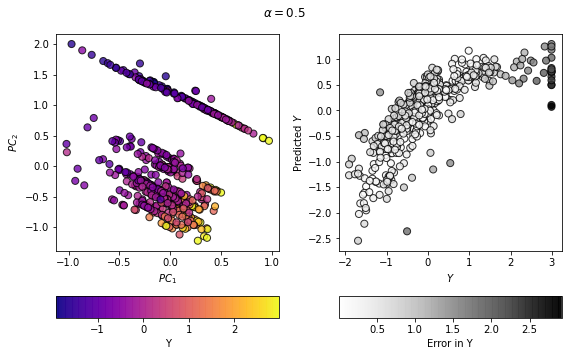

In [6]:
fig, axes = plt.subplots(2, 2, 
                         figsize=(8, 5),
                         gridspec_kw=dict(height_ratios=(1,0.1))
                        )

scatT = axes[0,0].scatter(T[:, 0], 
               T[:, 1], 
               s=50, 
               alpha=0.8,
               c=Y, 
               cmap=cmapX,  
               edgecolor='k'
              )
axes[0,0].set_xlabel(r"$PC_1$")
axes[0,0].set_ylabel(r"$PC_2$")
fig.colorbar(scatT, cax=axes[1,0], 
             label='Y', orientation='horizontal')

scatY = axes[0,1].scatter(Y, 
               Yp, 
               s=50, 
               alpha=0.8,
               c=np.abs(Y-Yp), 
               cmap=cmapY, 
               edgecolor='k')
fig.suptitle(r"$\alpha=$" + str(mixing))
axes[0,1].set_xlabel(r"$Y$")
axes[0,1].set_ylabel(r"Predicted $Y$")
fig.colorbar(scatY, cax=axes[1,1], 
             label='Error in Y', orientation='horizontal')

fig.tight_layout()

#### Surveying Many Mixing Parameters

There are fewer than 2 significant eigenpair(s). Adding 1 null eigenpair(s).


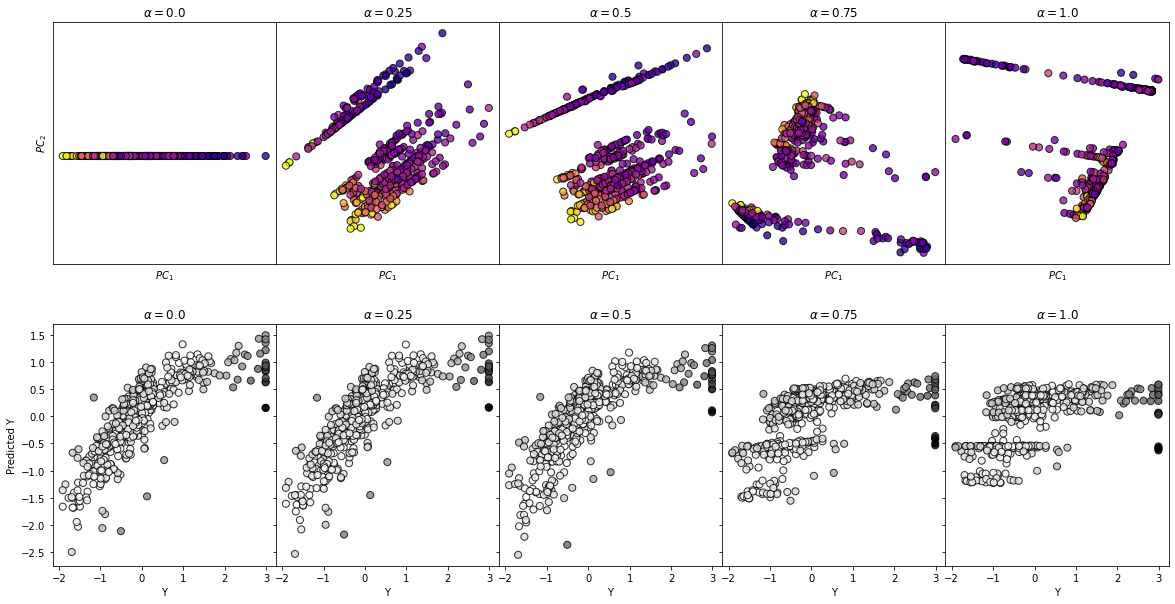

In [8]:
n_alpha = 5

fig, axes = plt.subplots(2, n_alpha, 
                         figsize=(4*n_alpha, 10),
                         sharey='row'
                        )

for i, mixing in enumerate(np.linspace(0, 1, n_alpha)):
    

    pcovr = PCovR(mixing=mixing, 
                      regularization=1E-8,
                      n_components=2, )
    pcovr.fit(X, Y)
    T = pcovr.transform(X)
    Yp = pcovr.predict(X)

    axes[0, i].scatter(T[:, 0], 
                       T[:, 1], 
                       s=50, 
                       alpha=0.8,
                       c=Y, 
                       cmap=cmapX,  
                       edgecolor='k'
                      )
    axes[0,i].set_title(r"$\alpha=$" + str(mixing))
    axes[0,i].set_xlabel(r"$PC_1$")
    axes[0,i].set_xticks([])
    axes[0,i].set_yticks([])

    axes[1, i].scatter(Y, 
                       Yp, 
                       s=50, 
                       alpha=0.8,
                       c=np.abs(Y-Yp), 
                       cmap=cmapY, 
                       edgecolor='k')
    axes[1,i].set_title(r"$\alpha=$" + str(mixing))
    axes[1,i].set_xlabel("Y")
    
axes[0,0].set_ylabel(r"$PC_2$")
axes[1,0].set_ylabel("Predicted Y")

fig.subplots_adjust(wspace=0, hspace=0.25)
plt.show()